In [1]:
%reset -f

import pandas as pd
import numpy as np
import scipy as sci
import sympy as sym
import math
import matplotlib
import matplotlib.pyplot as plt
import itertools
import gurobipy as gp
import pickle

from numpy import sqrt, exp, log, sin, cos, pi, polyfit, polyval, vander
from numpy.linalg import inv, pinv, det, matrix_rank, cond, lstsq, solve
from scipy.integrate import solve_ivp
from gurobipy import GRB
from pyinstrument import Profiler
from numba import jit

plt.style.use('default')                                    # 使用默认风格
plt.rcParams['figure.facecolor'] = 'white'                  # 将图形的背景颜色设置为白色
plt.rcParams['font.family'] = 'YaHei Consolas Hybrid'       # 字体确认
plt.rcParams['font.size'] = 12                              # 字体大小
plt.rcParams['axes.unicode_minus'] = False                  # 正常显示负号
%matplotlib inline
# matplotlib.use('TkAgg')

from Algorithms.Algorithm import *
from Algorithms.Params import *


In [27]:

class Args:
    def __init__(self, n,m,PT,MT,ni,parallel_dict,means_m=1,
                 pop_size=150,gene_size=150,
                 pc_max=0.8,pm_max=0.75,
                 pc_min=0.7,pm_min=0.2,
                 p_GS=0.5,p_LS=0.3,p_RS=0.2,
                 T=10,H=16,N_elite=4):
        self.n=n
        self.m=m
        self.Processing_Time=PT
        self.Processing_Machine=MT
        self.O_num=ni
        self.parallel_dict = parallel_dict
        self.means_m=means_m
        self.pop_size=pop_size
        self.gene_size=gene_size
        self.pc_max=pc_max
        self.pm_max=pm_max
        self.pc_min=pc_min
        self.pm_min=pm_min
        self.p_GS=p_GS
        self.p_LS=p_LS
        self.p_RS=p_RS
        self.T=T
        self.H=H
        self.N_elite=N_elite
        
D1 = pd.read_excel('工序机床表.xlsx')
D2 = pd.read_excel('工序耗时表.xlsx')

# 工件种类
n = D1.shape[0]
# 数控机床数目
m = 8
# 每种工件的工序数目
ni = [0 for i in range(n)]
# 每一个工序对应机床的集合
precess_Machine = []
# 每一个工序在precess_Machine对应的时间
precess_time = []
# means_m大于1表示用于解决FJSP问题
means_m = 2

# 并行关系字典：工件编号从0开始，工序数从0开始，机器编号从1开始
parallel_dict = {(0,1):(0,2),(0,2):(0,1),
                 (3,1):(3,2),(3,2):(3,1),
                 (4,1):(4,2),(4,2):(4,1),
                 (5,2):(5,3),(5,3):(5,2),
                 (6,2):(6,3),(6,3):(6,2),
                 (7,2):(7,3),(7,3):(7,2),
                 }

# 数据处理

for i in range(n):
    precess_Machine.append([])
    precess_time.append([])
for ind, row in D1.iterrows():
    for col in range(1, len(row)):
        curtime = D2.iloc[ind, col]
        pm = []
        pt = []
        if pd.isna(row[col]):
            break
        ni[row[0]] += 1
        ele = row[col].split(',')
        for e in ele:
            pm.append(int(e))
            pt.append(float(curtime))
        
        precess_Machine[ind].append(pm)
        precess_time[ind].append(pt)
        
args = Args(n,m,precess_time,precess_Machine,ni,parallel_dict,means_m)

Algo = Algorithms(args)


In [28]:
EP,genInfo=Algo.NSGA_main()

54293.0
基因：[6, 1, 1, 0, 7, 6, 4, 2, 5, 4, 2, 8, 7, 6, 4, 5, 0, 0, 7, 3, 6, 8, 7, 5, 4, 1, 3, 2, 5, 3, 0, 1, 0, 1, 1, 1, 0, 0, 3, 0, 0, 0, 2, 2, 0, 0, 2, 1, 0, 0, 0, 0, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0]
产品完工耗时： [52036.0, 52949.0, 36437.0, 54293.0, 49420.0, 51658.0, 35503.0, 47533.0, 44658.0]


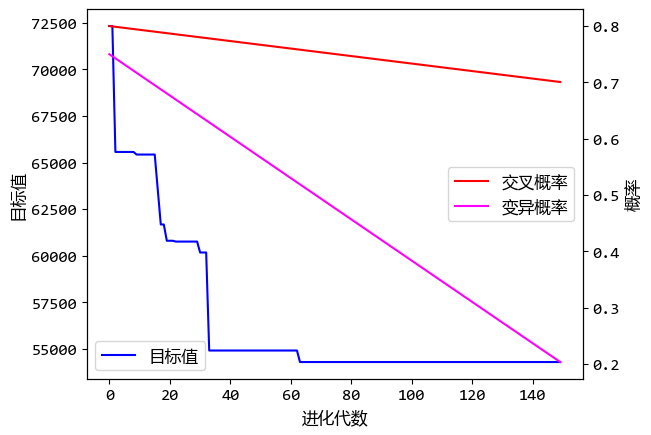

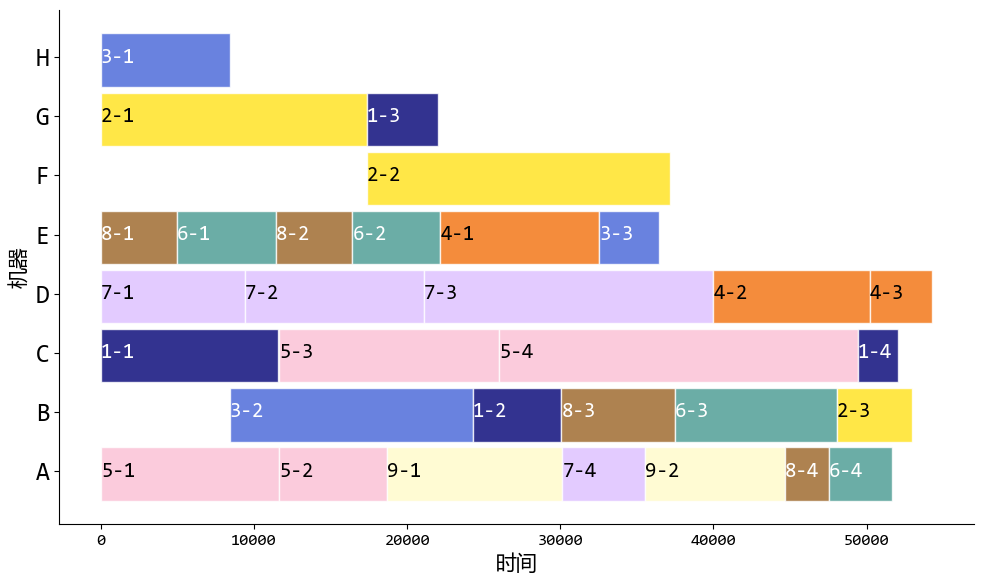

In [29]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## 第一问，按照优先级排序
fitness = []
for i in range(len(EP)):
    fitness.append((EP[i].fitness[0],EP[i].fitness[1], i))
import operator
fitness.sort(key = operator.itemgetter(0,1)) 
print(fitness[0][0])

print(f"基因：{EP[fitness[0][2]].CHS}")

print("产品完工耗时：",[EP[fitness[0][2]].JS.Jobs[i].endt
                 for i in range(len(EP[fitness[0][2]].JS.Jobs))])

# 绘制每代的最优目标以及自适应交叉变异图

# 创建一个新的图形
fig, ax1 = plt.subplots()

# 绘制第一个列表的折线图，使用左侧y轴
ax1.plot(genInfo[0], '-', color='blue')
ax1.set_ylabel('目标值')
ax1.set_xlabel('进化代数')

# 创建第二个坐标轴
ax2 = ax1.twinx()

# 绘制第二个列表的折线图，使用右侧坐标轴
ax2.plot(genInfo[1], '-', color='red')
ax2.plot(genInfo[2], '-', color='Magenta')
ax2.set_ylabel('概率', color='black')

# 添加图例
ax1.legend(['目标值'],loc='lower left')
ax2.legend(['交叉概率', '变异概率'], loc='center right')

# 保存图形
plt.savefig('q1Obj-pc-pm.png', dpi=300)

# 显示图形
plt.show()

# 设置工件和颜色对应关系
color_mapping = {
    0: '#000075', 
    1: '#ffe119', 
    2: '#4363d8', 
    3: '#F2700B', 
    4: '#fabed4', 
    5: '#469990', 
    6: '#dcbeff',
    7: '#9A6324', 
    8: '#fffac8',
    # 添加更多颜色和工件对应关系
}
# 创建甘特图
fig, ax = plt.subplots(figsize=(10, 6))

# 循环遍历每个机器
for i, Machine in enumerate(EP[fitness[0][2]].JS.Machines):
    start_times = Machine.start
    end_times = Machine.end
    on = Machine._on
    
    # 循环遍历当前机器的工序信息
    for j, task_info in enumerate(on):
        workpiece = task_info[0]  # 工件编号
        operation = task_info[1]  # 工序编号

        # 获取工件对应的颜色
        color = color_mapping.get(workpiece, 'gray')

        # 绘制甘特图条形
        ax.broken_barh([(start_times[j], end_times[j]-start_times[j])], (i*10, 9), facecolors=color, edgecolor='white')
        
        # 计算亮度
        bg_color = mcolors.to_rgb(color)
        brightness = (0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2])

        # 根据亮度决定文本颜色
        if brightness < 0.5:
            text_color = 'white'
        else:
            text_color = 'black'

        # 添加工件序号标签
        ax.text(start_times[j], i*10 + 5, str(workpiece + 1)+"-"+str(operation+1), ha='left', va='center', color=text_color, fontsize=15)

# 设置图形显示属性
# ax.set_ylim(0, len(EP[0].JS.Machines) * 10)
ax.set_xlabel('时间', fontsize=15)
ax.set_ylabel('机器', fontsize=15)
ax.set_yticks([i*10+5 for i in range(len(EP[0].JS.Machines))])
ax.set_yticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], fontsize=18)  # 根据实际机器的名称进行调整
#ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

# 隐藏顶部和右侧的边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# 调整甘特图条形颜色的透明度
for collection in ax.collections:
    collection.set_alpha(0.8)

# 显示甘特图
plt.tight_layout()
plt.savefig(f'q1甘特图-{fitness[0][0]}.png',dpi=400)
